In [63]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime
import os, csv, shapely, shapely.wkt, descartes, geopy, pickle, cloudpickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.options.display.float_format = '{:.4f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score

from sklearn import metrics as skm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from fairlearn.metrics import equalized_odds_ratio, MetricFrame, demographic_parity_difference, demographic_parity_ratio, selection_rate, equalized_odds_difference, true_positive_rate, false_positive_rate
from fairlearn.reductions import BoundedGroupLoss, ZeroOneLoss, ExponentiatedGradient, SquareLoss, AbsoluteLoss, GridSearch, DemographicParity, ErrorRate, EqualizedOdds
from sklearn.model_selection import KFold
from itertools import repeat

# pd.set_option('display.max_rows', 10)
# sns.set()
# sns.color_palette("ch:s=.25,rot=-.25")
np.set_printoptions(suppress=True)

In [64]:
CITY = "P_"
save_dir = CITY + 'clas_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
if not os.path.exists(save_dir_preprocess):
    os.makedirs(save_dir_preprocess)

if not os.path.exists(save_dir_models):
    os.makedirs(save_dir_models)
    
if not os.path.exists(save_dir_forecast):
    os.makedirs(save_dir_forecast)
    
if not os.path.exists(save_dir_fairst):
    os.makedirs(save_dir_fairst)

In [65]:
# load two datasets
df_pgh = pd.read_csv("data/pgh_grid_census.csv", index_col = 0)
df_spatially = pd.read_csv("data/spatially_sensitive_train.csv", index_col = 0)

censusTract = gpd.read_file('data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')
geo_df = pd.read_csv("data/pgh_grid_fit.csv")[["cell_num", "geometry", "centroid"]]
geo_df.to_csv(os.path.join(save_dir_forecast, CITY +"geo_df.csv"))
geo_df.head()

,cell_num,geometry,centroid
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194)
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908)
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479)
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194)
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908)


### plot station distribution

In [66]:
df_pgh_temp = df_pgh[["cell_num", "stations"]]
df_spatially_temp = df_spatially[["cell_num", "stations"]]

stations_dict = {}

for s in df_spatially_temp["cell_num"].unique():
    # print(df_spatially_temp[df_spatially_temp["cell_num"] == 628])
    stations_dict[s] = df_spatially_temp[df_spatially_temp["cell_num"] == s].iloc[-1]["stations"]
    
for stations in df_pgh_temp["cell_num"].unique():
    if stations not in stations_dict.keys():
        stations_dict[stations] = 0
        
geo_df["stations"] = 0

for index, row in geo_df.iterrows():
    row["stations"] = stations_dict[row["cell_num"]]
    geo_df.iloc[index] = row
    
for row,col in geo_df.iterrows():
    geo_df.at[row, 'geometry'] = shapely.wkt.loads(geo_df.loc[row]['geometry'])
    geo_df.at[row, 'centroid'] = shapely.wkt.loads(geo_df.loc[row]['centroid'])

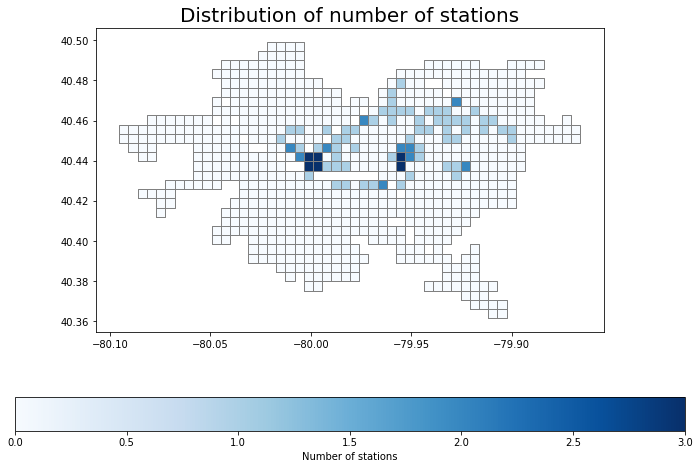

In [67]:
geo_df = gpd.GeoDataFrame(geo_df, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])

geo_df.plot(column="stations", cmap='Blues',edgecolor = "grey", figsize=(12, 8),  
                    legend = True, legend_kwds={'label': "Number of stations",'orientation': "horizontal"})
plt.title("Distribution of number of stations", fontsize=20)
plt.savefig(os.path.join(save_dir_preprocess, CITY +"stations_dist"), facecolor = 'w')

### outflow transform

In [68]:
df_outflow = df_spatially[["cell_num", "year", "month", "outflow"]]
df_outflow

,cell_num,year,month,outflow
0,687,2018,JUL,1
1,687,2018,AUG,0
2,687,2018,SEP,0
3,687,2018,OCT,0
4,687,2018,NOV,0
...,...,...,...,...
3340,1396,2020,AUG,9
3341,1396,2020,SEP,10
3342,1396,2020,OCT,6
3343,1396,2020,NOV,3


In [69]:
def month_trans(m):
    month_num_dict = {"JAN": 1, "FEB": 2, "MAR": 3, "APR": 4,
                     "MAY": 5, "JUN": 6, "JUL": 7, "AUG": 8,
                     "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12}
    
    return month_num_dict[m]

df_outflow["month"] = df_outflow["month"].apply(lambda x: month_trans(x))
df_outflow

/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cell_num,year,month,outflow
0,687,2018,7,1
1,687,2018,8,0
2,687,2018,9,0
3,687,2018,10,0
4,687,2018,11,0
...,...,...,...,...
3340,1396,2020,8,9
3341,1396,2020,9,10
3342,1396,2020,10,6
3343,1396,2020,11,3


In [70]:
outflow_complete = df_outflow

### weather

In [71]:
df_weather_raw = pd.read_csv("data/weatherpgh.csv")
df_weather_raw = df_weather_raw[df_weather_raw.YEAR.isin([2015, 2016, 2017, 2018, 2019])].reset_index(drop = True)
df_weather_raw.index = df_weather_raw.YEAR
df_weather_raw.drop(columns = ["YEAR"], inplace = True)

In [72]:
df_weather_temp = pd.DataFrame(index = np.arange(12), columns = [2015, 2016, 2017, 2018, 2019])

for index, row in df_weather_raw.iterrows():
    df_weather_temp[index] = row.values[:-1]

    year_l = [2015, 2016, 2017, 2018, 2019]
month_l = list(np.arange(12) + 1)

df_weather_final = pd.DataFrame(index = np.arange(60), columns = ["temp"])
df_weather_final["year"] = [x for item in year_l for x in repeat(item, 12)]
df_weather_final["month"] = month_l*5
df_weather_final.drop(index = [0, 1, 2, 3]).reset_index(drop = True, inplace = True)
df_weather_final.head()

,temp,year,month
0,NaN,2015,1
1,NaN,2015,2
2,NaN,2015,3
3,NaN,2015,4
4,NaN,2015,5


In [73]:
for index, row in df_weather_final.iterrows():
    year = row.year
    month = row.month
    df_weather_final.loc[index, "temp"] = df_weather_temp.loc[month-1, year]
    
df_weather_final.to_csv(os.path.join(save_dir_forecast, CITY +"df_weather_final.csv"))

df_merge1 = outflow_complete.merge(df_weather_final, on = ["year", 'month'], how = 'left')

### walk score dataset

In [74]:
# load two datasets
df_walk_score = df_spatially[["cell_num", "stations", "capacity", "walk_score", "bike_score", "transit_score", "nearby"]]
# extract parts from "nearby"

df_walk_score['nearby_bus'] = 0
df_walk_score['nearby_rail'] = 0
df_walk_score['nearby_other'] = 0
df_walk_score['nearby_routes'] = 0

for row,col in df_walk_score.iterrows():
    # if nearby == NaN
    if type(df_walk_score.loc[row]['nearby']) == float:
        df_walk_score.at[row, 'nearby_bus'] = 0
        df_walk_score.at[row, 'nearby_rail'] = 0
        df_walk_score.at[row, 'nearby_other'] = 0
        
    else:
        routes = df_walk_score.loc[row]['nearby']
        routes = routes.split(' ')
        nearby_routes = routes[0]
        nearby_bus = routes[3]
        nearby_rail = routes[5]
        nearby_other = routes[7]

        df_walk_score.at[row, 'nearby_bus'] = nearby_bus
        df_walk_score.at[row, 'nearby_rail'] = nearby_rail
        df_walk_score.at[row, 'nearby_other'] = nearby_other
        df_walk_score.at[row, 'nearby_routes'] = nearby_routes
        
df_walk_score.drop(columns = ["nearby"], inplace = True)
df_walk_score.reset_index(drop = True, inplace = True)

# censusTract

df_walk_score_temp = df_walk_score.groupby("cell_num").mean().reset_index()
for col in df_walk_score_temp.columns:
    df_walk_score_temp[col] = df_walk_score_temp[col].astype(int)
df_walk_score_temp.head()

/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,cell_num,stations,capacity,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,595,1,19,73,66,71,38,3,0,41
1,626,2,36,62,75,92,86,3,2,91
2,628,1,5,77,87,68,52,3,0,55
3,657,2,21,98,84,99,86,3,2,91
4,658,1,15,88,80,97,87,3,2,92


In [75]:
df_merge2 = df_merge1.merge(df_walk_score_temp, on = 'cell_num', how = "left")
df_merge2

,cell_num,year,month,outflow,temp,stations,capacity,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,687,2018,7,1,73.5000,1,10,76,82,86,58,3,2,63
1,687,2018,8,0,73.0000,1,10,76,82,86,58,3,2,63
2,687,2018,9,0,69.7000,1,10,76,82,86,58,3,2,63
3,687,2018,10,0,53.4000,1,10,76,82,86,58,3,2,63
4,687,2018,11,0,37.3000,1,10,76,82,86,58,3,2,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340,1396,2020,8,9,NaN,1,7,60,74,63,26,0,0,26
3341,1396,2020,9,10,NaN,1,7,60,74,63,26,0,0,26
3342,1396,2020,10,6,NaN,1,7,60,74,63,26,0,0,26
3343,1396,2020,11,3,NaN,1,7,60,74,63,26,0,0,26


### census tract dataset

In [76]:
# for forecast
df_station_cap = df_spatially[["cell_num", "stations", "capacity"]].groupby("cell_num").mean().reset_index()
df_station_cap.stations = df_station_cap.stations.astype(int)
df_station_cap.capacity = df_station_cap.capacity.astype(int)
df_station_cap.to_csv(os.path.join(save_dir_forecast, CITY +"df_station_cap.csv"))

In [77]:
df_pgh_census = df_pgh[["cell_num", "median_hh_income", "population_16yrs+", "total_households", "mean_travel_time_to_work",
        "Workers_16yrs+", "perc_public", "perc_walk", "perc_other", "perc_employed", 
        "perc_unemployed", "wfh", "own_alone", "carpool"]]
df_pgh_census.to_csv(os.path.join(save_dir_forecast, CITY +"df_pgh_census.csv"))
df_pgh_census

,cell_num,median_hh_income,population_16yrs+,total_households,mean_travel_time_to_work,Workers_16yrs+,perc_public,perc_walk,perc_other,perc_employed,perc_unemployed,wfh,own_alone,carpool
0,51,67409,2660,1306,23,1695,0.1563,0.0372,0.0000,0.6346,0.0481,58,1083,226
1,52,67409,2660,1306,23,1695,0.1563,0.0372,0.0000,0.6346,0.0481,58,1083,226
2,82,67409,2660,1306,23,1695,0.1563,0.0372,0.0000,0.6346,0.0481,58,1083,226
3,83,67409,2660,1306,23,1695,0.1563,0.0372,0.0000,0.6346,0.0481,58,1083,226
4,84,67409,2660,1306,23,1695,0.1563,0.0372,0.0000,0.6346,0.0481,58,1083,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,30089,2394,1391,26,1066,0.1811,0.0000,0.0000,0.4628,0.0706,179,581,113
724,1588,30089,2394,1391,26,1066,0.1811,0.0000,0.0000,0.4628,0.0706,179,581,113
725,1589,30089,2394,1391,26,1066,0.1811,0.0000,0.0000,0.4628,0.0706,179,581,113
726,1619,30089,2394,1391,26,1066,0.1811,0.0000,0.0000,0.4628,0.0706,179,581,113


In [78]:
# # for fairst forecast
# df_pgh_census_copy = df_pgh_census.copy()
# df_pgh_census_copy["income_group"] = 0
# df_pgh_census_copy["median_hh_income"] = df_pgh_census_copy["median_hh_income"].replace("-", 0)
# df_pgh_census_copy.median_hh_income = df_pgh_census_copy.median_hh_income.astype(int)
# # df_pgh_census_copy.median_hh_income.fillna(0)
# for row, col in df_pgh_census_copy.iterrows():
#     if df_pgh_census_copy.loc[row]["median_hh_income"] > 50000:
#         df_pgh_census_copy.at[row, "income_group"] = 1
# df_pgh_census_copy[["cell_num", "income_group"]].to_csv(os.path.join(save_dir_fairst, "df_income.csv"))

In [79]:
df = df_merge2.merge(df_pgh_census, on = "cell_num", how = 'left')
df = df.fillna(0)
df

,cell_num,year,month,outflow,temp,stations,capacity,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,median_hh_income,population_16yrs+,total_households,mean_travel_time_to_work,Workers_16yrs+,perc_public,perc_walk,perc_other,perc_employed,perc_unemployed,wfh,own_alone,carpool
0,687,2018,7,1,73.5000,1,10,76,82,86,58,3,2,63,-,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
1,687,2018,8,0,73.0000,1,10,76,82,86,58,3,2,63,-,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
2,687,2018,9,0,69.7000,1,10,76,82,86,58,3,2,63,-,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
3,687,2018,10,0,53.4000,1,10,76,82,86,58,3,2,63,-,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
4,687,2018,11,0,37.3000,1,10,76,82,86,58,3,2,63,-,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340,1396,2020,8,9,0.0000,1,7,60,74,63,26,0,0,26,15299,1003,694,28,310,0.3419,0.0516,0.0000,0.3091,0.0080,28,160,0
3341,1396,2020,9,10,0.0000,1,7,60,74,63,26,0,0,26,15299,1003,694,28,310,0.3419,0.0516,0.0000,0.3091,0.0080,28,160,0
3342,1396,2020,10,6,0.0000,1,7,60,74,63,26,0,0,26,15299,1003,694,28,310,0.3419,0.0516,0.0000,0.3091,0.0080,28,160,0
3343,1396,2020,11,3,0.0000,1,7,60,74,63,26,0,0,26,15299,1003,694,28,310,0.3419,0.0516,0.0000,0.3091,0.0080,28,160,0


In [80]:
df["median_hh_income"] = df["median_hh_income"].replace("-", 0)
df.median_hh_income = df.median_hh_income.astype(int)

### income

In [81]:
print(df["median_hh_income"].describe())

count     3345.0000
mean     53813.6637
std      31303.4149
min          0.0000
25%      27003.0000
50%      54457.0000
75%      69491.0000
max     133750.0000
Name: median_hh_income, dtype: float64


In [82]:
# training set
df["income_group"] = 0
for row, col in df.iterrows():
    if df.loc[row]["median_hh_income"] > 50000:
        df.at[row, "income_group"] = 1
df.drop(columns = ["median_hh_income"], inplace = True)

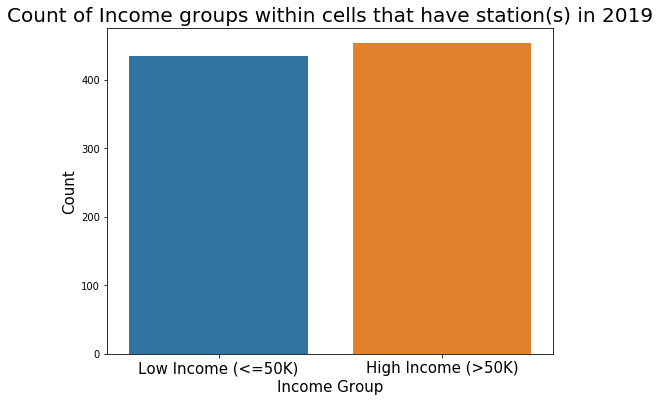

In [83]:
plt.figure(figsize = (8, 6))
sns.countplot(df[df.year == 2019]["income_group"])
plt.title("Count of Income groups within cells that have station(s) in 2019", fontsize = 20)
plt.xticks([0, 1], ["Low Income (<=50K)", "High Income (>50K)"], fontsize = 15)
plt.xlabel("Income Group", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.savefig(os.path.join(save_dir_preprocess, CITY +"income_group_2019"))

### outflow class

In [84]:
df["outflow_class"] = 0
for row, col in df.iterrows():
        
    if df.loc[row]["outflow"] > df.outflow.mean():
        df.at[row, "outflow_class"] = 1
        
df.drop(columns = ["outflow"], inplace = True)

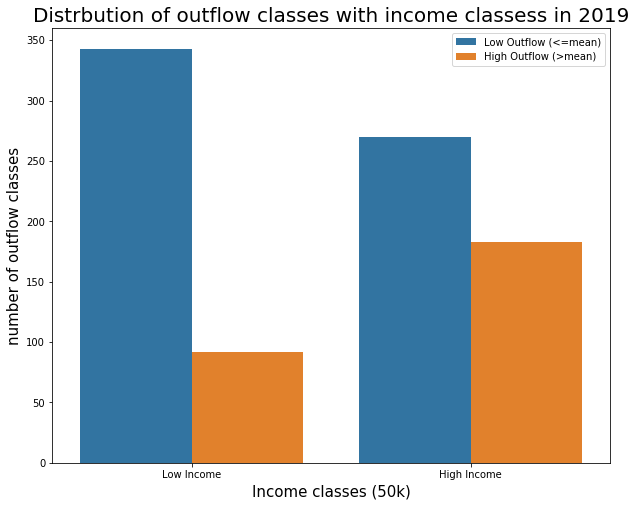

In [85]:
# sns.set(rc={'figure.figsize':(8, 6)})
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.countplot(df[df.year == 2019]['income_group'], hue = df[df.year == 2019]["outflow_class"])
# ax.set_title('Count of outflow classes for two income groups')
ax.set_ylabel('number of outflow classes', fontsize = 15)
ax.set_xlabel("Income classes (50k)", fontsize = 15)
plt.legend(["Low Outflow (<=mean)", "High Outflow (>mean)"])

# # plt.savefig("fig1")
plt.xticks([0, 1], ['Low Income', 'High Income'])
plt.title("Distrbution of outflow classes with income classess in 2019", fontsize = 20)
plt.savefig(os.path.join(save_dir_preprocess, CITY+"outflow_income_group_2019"))

In [86]:
df_low_income = df[df.year == 2019][df[df.year == 2019]["income_group"] == 0]
df_high_income = df[df.year == 2019][df[df.year == 2019]["income_group"] == 1]

low_income_low_outflow = len(df_low_income[df_low_income["outflow_class"] == 0])/len(df_low_income)
low_income_high_outflow = len(df_low_income[df_low_income["outflow_class"] == 1])/len(df_low_income)

high_income_low_outflow = len(df_high_income[df_high_income["outflow_class"] == 0])/len(df_high_income)
high_income_high_outflow = len(df_high_income[df_high_income["outflow_class"] == 1])/len(df_high_income)

fig2_df = pd.DataFrame({"Outflow": [low_income_high_outflow*100, high_income_high_outflow*100],
                       "Income": ["Low", "High"]})
fig2_df

,Outflow,Income
0,21.1494,Low
1,40.3974,High


Text(0.5, 1.0, 'Percentage of high outflow classes in 2019')

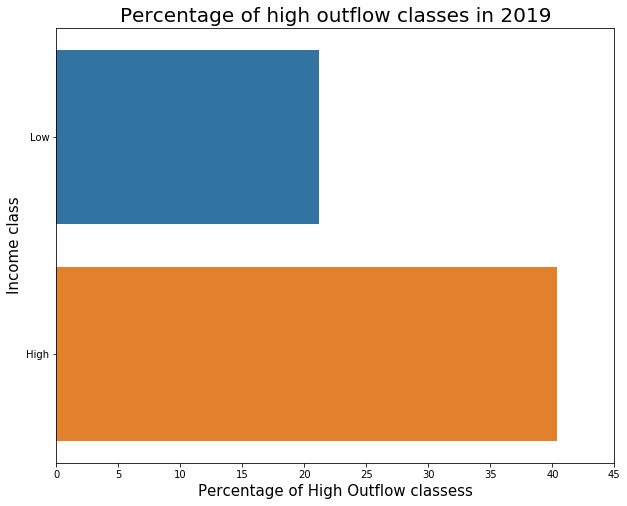

In [87]:
# sns.set(rc={'figure.figsize':(8, 6)})
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.barplot(data = fig2_df, x = 'Outflow', y = 'Income')

ax.set_ylabel('Income class', fontsize = 15)
ax.set_xlabel("Percentage of High Outflow classess", fontsize = 15)
ax.set_xlim(0, 45)
plt.title("Percentage of high outflow classes in 2019", fontsize = 20)
# plt.savefig(os.path.join(save_dir_preprocess, CITY+"outflow_income_group2_2019"))

In [88]:
# Train Test split
df_1518 = df[df["year"].isin([2015, 2016, 2017, 2018])] # 1032
df_19 = df[df["year"].isin([2019])]

df_1518 = df_1518.drop(columns = ["year"])
df_19 = df_19.drop(columns = ["year"])

In [89]:
X_train = df_1518.drop(columns = ["outflow_class", "cell_num"])
X_test = df_19.drop(columns = ["outflow_class", "cell_num"])

y_train = df_1518["outflow_class"]
y_test = df_19["outflow_class"]

A_train = df_1518["income_group"]
A_test = df_19["income_group"]

y_test_cell_num = df_19[["cell_num", "income_group"]]
y_test_cell_num

,cell_num,income_group
6,687,0
7,687,0
8,687,0
9,687,0
10,687,0
...,...,...
3328,1396,0
3329,1396,0
3330,1396,0
3331,1396,0


In [90]:
# reset index
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
A_train.reset_index(drop = True, inplace = True)
A_test.reset_index(drop = True, inplace = True)

X_train.to_csv(os.path.join(save_dir_forecast, CITY + "X_train.csv"))

### 3 Fairness models

In [91]:
# summary df
model_summary = pd.DataFrame(0, columns = ["accuracy", "accuracy_diff", "equalized_odds_diff"], 
                             index = ["random_forest", "exp_grad", "grid_search"])

# model_summary.to_csv(os.path.join(save_dir_models, "model_summary.csv"))

In [92]:
# param_grid = { # 'bootstrap': [True, False],
#  'max_depth': [10, 20, 40, 50, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5],
#  'n_estimators': [10, 20, 40, 50, None]}

# # Create a based model
# rf = RandomForestClassifier(random_state = 42)
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose = 1, scoring = 'f1') # r2 / neg_mean_absolute_error
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [93]:
# # save grid search model
# with open(os.path.join(save_dir_models, CITY+"random_forest_gs_best.csv"), 'w') as f:
#     for key in grid_search.best_params_.keys():
#         f.write("%s,%s\n"%(key, grid_search.best_params_[key]))
#     f.write("%s, %s\n"%("scoring", grid_search.scoring))

In [94]:
# print(grid_search.best_estimator_)
# print(grid_search.best_score_)
# grid_search_all_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["neg_mean_absolute_error"])], axis=1)
# grid_search_all_res.to_csv(os.path.join(save_dir_models, CITY+"random_forest_gs_all.csv"))

In [95]:
# # save model
# rf_best = grid_search.best_estimator_

In [96]:
# Pkl_Filename = "random_forest.pkl"  
# with open(os.path.join(save_dir_models, CITY+Pkl_Filename), 'wb') as file:  
#     pickle.dump(rf_best, file)

In [97]:
rf_best = pickle.load(open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb'))

accuracy              0.9113
true_positive_rate    0.8640
false_positive_rate   0.0613
dtype: object
------------------------------
             accuracy true_positive_rate false_positive_rate
income_group                                                
0              0.9005             0.7546              0.0478
1              0.9187             0.9082              0.0732
true_positive_rate diff: 0.15359
false_positive_rate diff: 0.02539
equalized_odds_difference: 0.15359
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90a840c790>,
      dtype=object)

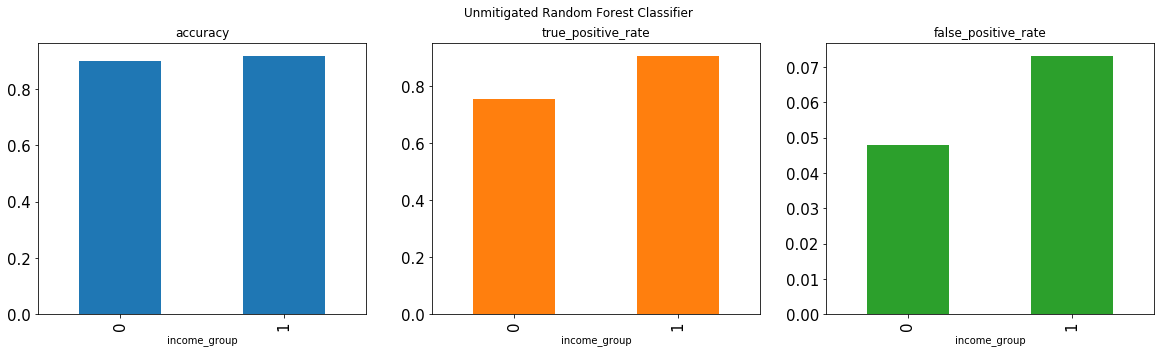

In [98]:
'''
TRAIN SET
'''

# rf_best.fit(X_train, y_train)
y_pred_rf_gs_train = rf_best.predict(X_train)

# Metric evaluation
metric_frame_rf_gs_train = MetricFrame(metric = 
                                    {"accuracy": skm.accuracy_score,
                                    "true_positive_rate": true_positive_rate,
                                    "false_positive_rate": false_positive_rate},
                                   sensitive_features = A_train,
                                   y_true = y_train,
                                   y_pred = y_pred_rf_gs_train)

rf_gs_eo_diff_train = equalized_odds_difference(y_train, y_pred_rf_gs_train, sensitive_features = A_train)
print(metric_frame_rf_gs_train.overall)
print("-"*30)
print(metric_frame_rf_gs_train.by_group)
print("true_positive_rate diff:", "{:.5f}".format(metric_frame_rf_gs_train.difference()["true_positive_rate"]))
print("false_positive_rate diff:", "{:.5f}".format(metric_frame_rf_gs_train.difference()["false_positive_rate"]))
print("equalized_odds_difference:", "{:.5f}".format(rf_gs_eo_diff_train))
print("-"*30)
# # # save model
# model_summary.loc["random_forest", "accuracy"] = metric_frame_rf_gs.overall["accuracy"]
# model_summary.loc["random_forest", "accuracy_diff"] = metric_frame_rf_gs.difference()["accuracy"]
# model_summary.loc["random_forest", "equalized_odds_diff"] = rf_gs_eo_diff

# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs_train.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Unmitigated Random Forest Classifier', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"random_forest_metric"))

accuracy              0.8615
true_positive_rate    0.6873
false_positive_rate   0.0604
dtype: object
------------------------------
             accuracy true_positive_rate false_positive_rate
income_group                                                
0              0.8529             0.4565              0.0408
1              0.8698             0.8033              0.0852
accuracy diff: 0.01688
true_positive_rate diff: 0.34676
false_positive_rate diff: 0.04437
equalized_odds_difference: 0.34676
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90c4f09690>,
      dtype=object)

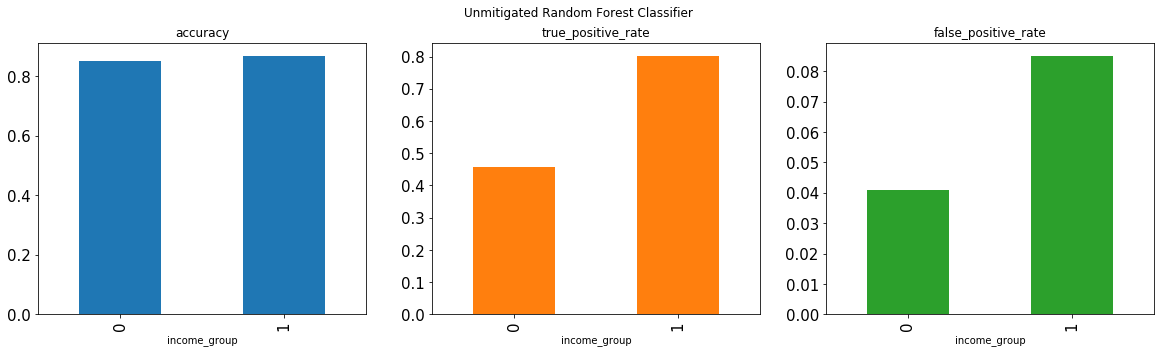

In [99]:
'''
TEST SET
'''
rf_best.fit(X_train, y_train)
y_pred_rf_gs = rf_best.predict(X_test)

# Metric evaluation
metric_frame_rf_gs = MetricFrame(metric = 
                                    {"accuracy": skm.accuracy_score,
                                    "true_positive_rate": true_positive_rate,
                                    "false_positive_rate": false_positive_rate},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_rf_gs)

rf_gs_eo_diff = equalized_odds_difference(y_test, y_pred_rf_gs, sensitive_features = A_test)
print(metric_frame_rf_gs.overall)
print("-"*30)
print(metric_frame_rf_gs.by_group)

print("accuracy diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["accuracy"]))
print("true_positive_rate diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["true_positive_rate"]))
print("false_positive_rate diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["false_positive_rate"]))
print("equalized_odds_difference:", "{:.5f}".format(rf_gs_eo_diff))

print("-"*30)
# # save model
model_summary.loc["random_forest", "accuracy"] = metric_frame_rf_gs.overall["accuracy"]
model_summary.loc["random_forest", "accuracy_diff"] = metric_frame_rf_gs.difference()["accuracy"]
model_summary.loc["random_forest", "equalized_odds_diff"] = rf_gs_eo_diff

# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Unmitigated Random Forest Classifier', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"random_forest_metric"))

### 3.2 Exponentiated Gradient (constraint: EqualizedOdds)

In [100]:
# # diff_bound_l = np.arange(0, 100000, 2000)/10000000
# # diff_bound_l = diff_bound_l[1:]
# # diff_bound_l = [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5]

# diff_bound_l = np.linspace(0, 1, 100)
# diff_bound_l

In [101]:
# # cross validation for EG
# # implement K-fold cross validation

# exp_grad_result = pd.DataFrame({"diff_bound": diff_bound_l})

# for i in range(len(diff_bound_l)):
#     cv_acc_ls = []
#     cv_equalized_odds_ls = []
#     cv_tpr_ls = []
#     cv_fpr_ls = []
    
#     print(i)
#     diff_bound = diff_bound_l[i]
    
#     # train-valid split
#     kfold = KFold(3, shuffle = True, random_state = 42)
#     for train, valid in kfold.split(X_train):
#         # print("CV")
#         X_train_exp = X_train.loc[train]
#         y_train_exp = y_train.loc[train]
#         A_train_exp = A_train.loc[train]

#         X_valid = X_train.loc[valid]
#         y_valid = y_train.loc[valid]
#         A_valid = A_train.loc[valid]

#         # avoid failure of optimization
#         # try:
#         # train
#         constraint = EqualizedOdds(difference_bound = diff_bound)
#         exp_grad = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
#         exp_grad.fit(X_train_exp, y_train_exp, sensitive_features = A_train_exp)
#         y_valid_pred = exp_grad.predict(X_valid, random_state = 42)


#         # performance validation #
#         metric_frame_eg_cv = MetricFrame(metric = {"accuracy": skm.accuracy_score,  
#                                                    "true_positive_rate": true_positive_rate, 
#                                                    "false_positive_rate": false_positive_rate},
#                                          sensitive_features = A_valid, 
#                                          y_true = y_valid, 
#                                          y_pred = y_valid_pred)

#         cv_acc_ls.append(metric_frame_eg_cv.overall["accuracy"])
#         cv_equalized_odds_ls.append(equalized_odds_difference(y_valid, y_valid_pred, sensitive_features = A_valid))
#         cv_tpr_ls.append(metric_frame_eg_cv.difference()["true_positive_rate"])
#         cv_fpr_ls.append(metric_frame_eg_cv.difference()["false_positive_rate"])

# #         except:
# #             cv_acc_ls.append(np.nan)
# #             cv_equalized_odds_ls.append(np.nan)
# #             cv_tpr_ls.append(np.nan)
# #             cv_fpr_ls.append(np.nan)

#     exp_grad_result.loc[i, "cv_avg_acc"] = np.nanmean(np.array(cv_acc_ls))
#     exp_grad_result.loc[i, "cv_avg_equalized_odds_diff"] = np.nanmean(np.array(cv_equalized_odds_ls))
#     exp_grad_result.loc[i, "cv_avg_tpr_diff"] = np.nanmean(np.array(cv_tpr_ls))
#     exp_grad_result.loc[i, "cv_avg_fpr_diff"] = np.nanmean(np.array(cv_fpr_ls))

#     # exp_grad_result.to_csv(os.path.join(save_dir_models, CITY+"exp_grad_valid_res.csv"))

In [102]:
# exp_grad_result_sorted = exp_grad_result.sort_values("cv_avg_equalized_odds_diff")
# exp_grad_result_sorted.reset_index(drop = True, inplace = True)
# exp_grad_result_sorted.to_csv(os.path.join(save_dir_models, CITY +"exp_grad_valid_res.csv"))

In [103]:
# # best_eg_index = exp_grad_result[exp_grad_result.cv_avg_mae_diff == exp_grad_result.cv_avg_mae_diff.min()].index[0]
# # print("best upper bound for BGL:", diff_bound_l[best_eg_index])

# # plot
# plt.figure(figsize = (25, 8))
# plt.plot(exp_grad_result.diff_bound, exp_grad_result.cv_avg_equalized_odds_diff)
# plt.scatter(exp_grad_result.iloc[exp_grad_result.cv_avg_equalized_odds_diff.argmin()].diff_bound, exp_grad_result.iloc[exp_grad_result.cv_avg_equalized_odds_diff.argmin()].cv_avg_equalized_odds_diff, color = "red")
# # plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
# plt.xlabel("upper bound in BGL", fontsize = 15)
# plt.ylabel("MAE difference", fontsize = 15)
# plt.text(x = exp_grad_result.iloc[exp_grad_result.cv_avg_equalized_odds_diff.argmin()].diff_bound+0.0005, y = exp_grad_result.iloc[exp_grad_result.cv_avg_equalized_odds_diff.argmin()].cv_avg_equalized_odds_diff, s = 'min', color = "red")
# plt.title("Cross Validation MAE diff for parameter 'upper_bound' \nin Bounded Group Loss for Exponentiated Gradient", fontsize = 18)
# plt.title("Exponentiated Gradient cross validation result: MAE difference vs. 'upper_bound' in BGL ", fontsize = 18)
# plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_valid_res"))

In [104]:
# # predict on test set
# constraint = EqualizedOdds(difference_bound = exp_grad_result_sorted.diff_bound[0])
# eg_best = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
# eg_best.fit(X_train, y_train, sensitive_features = A_train)
# y_pred_eg = eg_best.predict(X_test, random_state = 42)

In [105]:
# # save model
# Pkl_Filename = "exp_grad.pkl"  
# with open(os.path.join(save_dir_models, CITY + Pkl_Filename), 'wb') as file:  
#     cloudpickle.dump(eg_best, file)

In [106]:
eg_best = pickle.load(open(os.path.join(save_dir_models, CITY + "exp_grad.pkl"), 'rb'))
y_pred_eg = eg_best.predict(X_test, random_state = 42)

accuracy              0.8945
true_positive_rate    0.8675
false_positive_rate   0.0899
dtype: object
------------------------------
             accuracy true_positive_rate false_positive_rate
income_group                                                
0              0.8941             0.8589              0.0935
1              0.8948             0.8710              0.0867
------------------------------
accuracy diff: 0.00073
true_positive_rate diff: 0.01207
false_positive_rate diff: 0.00677
equalized_odds_difference: 0.01207
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90a5f0d150>,
      dtype=object)

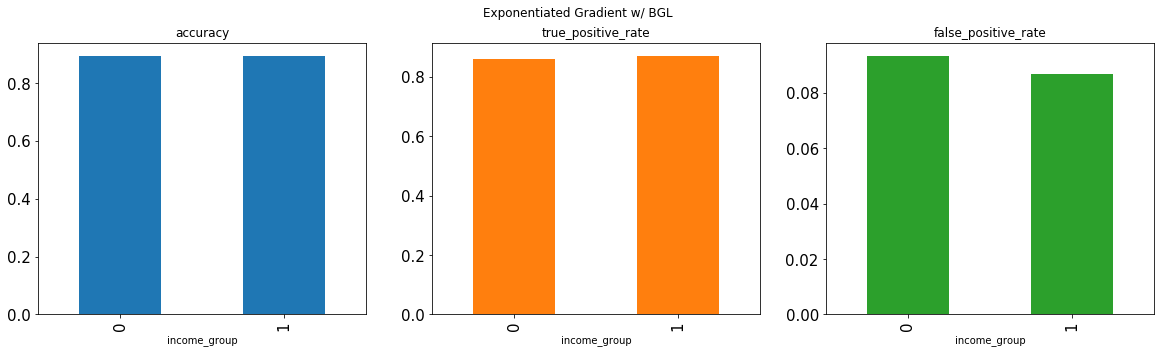

In [107]:
'''
TRAIN SET
'''
y_pred_eg_train = eg_best.predict(X_train, random_state = 42)
metric_frame_eg_train = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                    "true_positive_rate": true_positive_rate,
                                    "false_positive_rate": false_positive_rate},
                                   sensitive_features = A_train,
                                   y_true = y_train,
                                   y_pred = y_pred_eg_train)

eg_eo_diff_train = equalized_odds_difference(y_train, y_pred_eg_train, sensitive_features = A_train)

print(metric_frame_eg_train.overall)
print("-"*30)
print(metric_frame_eg_train.by_group)
print("-"*30)
print("accuracy diff:", "{:.5f}".format(metric_frame_eg_train.difference()["accuracy"]))
print("true_positive_rate diff:", "{:.5f}".format(metric_frame_eg_train.difference()["true_positive_rate"]))
print("false_positive_rate diff:", "{:.5f}".format(metric_frame_eg_train.difference()["false_positive_rate"]))
print("equalized_odds_difference:", "{:.5f}".format(eg_eo_diff_train))
print("-"*30)

# model_summary.loc["exp_grad", "accuracy"] = metric_frame_eg.overall["accuracy"]
# model_summary.loc["exp_grad", "accuracy_diff"] = metric_frame_eg.difference()["accuracy"]
# model_summary.loc["exp_grad", "equalized_odds_diff"] = eg_eo_diff

# # save model
# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)


metric_frame_eg_train.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Exponentiated Gradient w/ BGL', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_metric"))

accuracy              0.8570
true_positive_rate    0.7309
false_positive_rate   0.0865
dtype: object
------------------------------
             accuracy true_positive_rate false_positive_rate
income_group                                                
0              0.8575             0.5870              0.0700
1              0.8565             0.8033              0.1074
------------------------------
accuracy diff: 0.00096
true_positive_rate diff: 0.21632
false_positive_rate diff: 0.03744
equalized_odds_difference: 0.21632
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90c3c32310>,
      dtype=object)

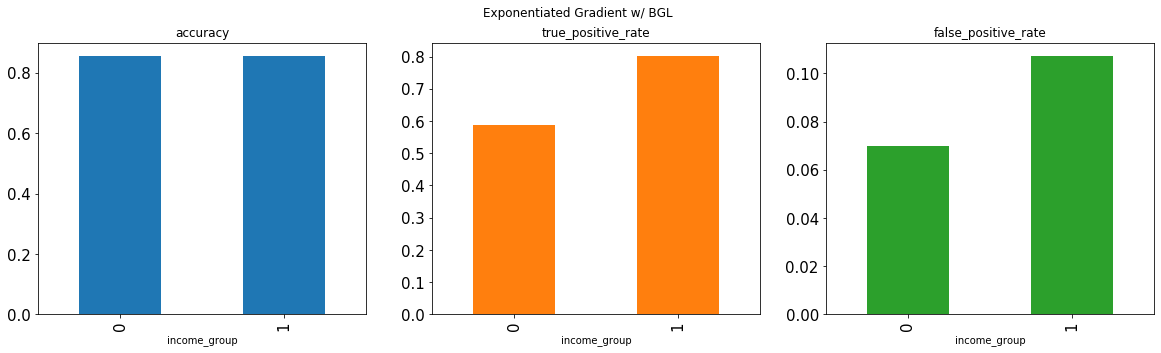

In [108]:
'''
TEST SET
'''
metric_frame_eg = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                    "true_positive_rate": true_positive_rate,
                                    "false_positive_rate": false_positive_rate},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_eg)

eg_eo_diff = equalized_odds_difference(y_test, y_pred_eg, sensitive_features = A_test)

print(metric_frame_eg.overall)
print("-"*30)
print(metric_frame_eg.by_group)
print("-"*30)
print("accuracy diff:", "{:.5f}".format(metric_frame_eg.difference()["accuracy"]))
print("true_positive_rate diff:", "{:.5f}".format(metric_frame_eg.difference()["true_positive_rate"]))
print("false_positive_rate diff:", "{:.5f}".format(metric_frame_eg.difference()["false_positive_rate"]))
print("equalized_odds_difference:", "{:.5f}".format(eg_eo_diff))
print("-"*30)

model_summary.loc["exp_grad", "accuracy"] = metric_frame_eg.overall["accuracy"]
model_summary.loc["exp_grad", "accuracy_diff"] = metric_frame_eg.difference()["accuracy"]
model_summary.loc["exp_grad", "equalized_odds_diff"] = eg_eo_diff

# # save model
# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)


metric_frame_eg.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Exponentiated Gradient w/ BGL', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_metric"))

### 3) Grid Search (constraint: BGL)

In [109]:
# def calc_dominant_avg_res(predictors, X_valid, y_valid, A_valid):
    
#     # Loop through all predictors
#     acc_all = []
# #     acc_diff_all = []
#     equalized_odds_diff_all = []
# #     tpr_diff_all = []
# #     fpr_diff_all = []

#     for i in range(len(predictors)):
#         metric_frame = MetricFrame(metric = {"accuracy": skm.accuracy_score,
#                                              "true_positive_rate": true_positive_rate,
#                                              "false_positive_rate": false_positive_rate},
#                                    sensitive_features = A_valid,
#                                    y_true = y_valid, 
#                                    y_pred = predictors[i].predict(X_valid))
        
#         acc_all.append(metric_frame_eg_cv.overall["accuracy"])
# #         acc_diff_all.append(metric_frame_eg_cv.difference()["accuracy"])
# #         tpr_diff_all.append(metric_frame_eg_cv.difference()["true_positive_rate"])
# #         fpr_diff_all.append(metric_frame_eg_cv.difference()["false_positive_rate"])
#         equalized_odds_diff_all.append(equalized_odds_difference(y_valid, predictors[i].predict(X_valid), sensitive_features = A_valid))

        
#     # get dominant models
#     all_results = pd.DataFrame({"predictors:": predictors, "acc": acc_all, "diff": equalized_odds_diff_all})
#     dominated = []
#     for row in all_results.itertuples():
#         '''
#         want the models that have the high accuracy with low eo_difference
#         thus, we select model M if all of other models with higher accuracy than M also have higher difference than M.
#         # i.e. M has the lowest difference among all of the models that have higher accuracy than it.
#         '''
#         difference = all_results["diff"][all_results["acc"] >= row.acc]
#         if row.diff <= difference.min():
#             dominated.append(row[1])

    
#     # loop all of the dominated models
#     acc_dominated = []
#     acc_diff_dominated = []
#     equalized_odds_diff_dominated = []

#     for i in range(len(dominated)):
#         metric_frame_dominated = MetricFrame(metric={"accuracy": skm.accuracy_score,
#                                              "true_positive_rate": true_positive_rate,
#                                              "false_positive_rate": false_positive_rate},
#                                    sensitive_features = A_valid,
#                                    y_true = y_valid,
#                                    y_pred = dominated[i].predict(X_valid))

#         acc_dominated.append(metric_frame.overall["accuracy"])
#         acc_diff_dominated.append(metric_frame_dominated.difference()['accuracy'])
#         equalized_odds_diff_dominated.append(equalized_odds_difference(y_valid, dominated[i].predict(X_valid), sensitive_features = A_valid))

#     acc_dominated = np.array(acc_dominated)
#     acc_diff_dominated = np.array(acc_diff_dominated)
#     equalized_odds_diff_dominated = np.array(equalized_odds_diff_dominated)

#     return np.nanmean(acc_dominated), np.nanmean(acc_diff_dominated), np.nanmean(equalized_odds_diff_dominated)


In [110]:
# # cross validation for grid search 
# # implement K-fold cross validation
# grid_size_ls = np.arange(0, 22, 2)[1:]

# grid_search_result = pd.DataFrame({"grid_size": grid_size_ls})

# for i in np.arange(len(grid_size_ls)):
#     print(i)
#     g_size = grid_size_ls[i]
    
#     # train-valid split
#     kfold = KFold(3, shuffle = True, random_state = 42)
#     for train, valid in kfold.split(X_train):
#         # print("CV")
#         X_train_gs = X_train.loc[train]
#         y_train_gs = y_train.loc[train]
#         A_train_gs = A_train.loc[train]

#         X_valid = X_train.loc[valid]
#         y_valid = y_train.loc[valid]
#         A_valid = A_train.loc[valid]

#         # avoid failure of optimization
#         # try:
#             # train
#         constraint = EqualizedOdds(difference_bound = exp_grad_result_sorted.diff_bound[0])
# #             eg_best = ExponentiatedGradient(estimator = rf_best, constraints = econstraint)
# #             eg_best.fit(X_train, y_train, sensitive_features = A_train)
# #             y_pred_eg = eg_best.predict(X_test, random_state = 42)

#         mitigator = GridSearch(estimator = rf_best, constraints = constraint, grid_size = g_size)

#         mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
#         predictors = mitigator.predictors_

#         # calculate dominant models res
#         dominant_res = calc_dominant_avg_res(predictors, X_valid, y_valid, A_valid)

#         grid_search_result.loc[i, "cv_avg_acc"] = dominant_res[0]
#         grid_search_result.loc[i, "cv_avg_acc_diff"] = dominant_res[1]
#         grid_search_result.loc[i, "cv_equalized_odds_diff"] = dominant_res[2]

# #         except:
# #             grid_search_result.loc[i, "cv_avg_r2"] = np.nan
# #             grid_search_result.loc[i, "cv_avg_r2_diff"] = np.nan
# #             grid_search_result.loc[i, "cv_avg_mae"] = np.nan
# #             grid_search_result.loc[i, "cv_avg_mae_diff"] = np.nan

#     grid_search_result.to_csv(os.path.join(save_dir_models, CITY+"grid_search_valid_res.csv"))

In [111]:
# grid_search_result

In [112]:
# best_gs_index = grid_search_result[grid_search_result.cv_equalized_odds_diff == grid_search_result.cv_equalized_odds_diff.min()].index[0]
# print("best grid size for Grid Search:", grid_size_ls[best_gs_index])

# # plot
# plt.figure(figsize = (25, 8))
# plt.plot(grid_search_result.grid_size, grid_search_result.cv_equalized_odds_diff)
# plt.scatter(grid_search_result.iloc[grid_search_result.cv_equalized_odds_diff.argmin()].grid_size, grid_search_result.iloc[grid_search_result.cv_equalized_odds_diff.argmin()].cv_equalized_odds_diff, color = "red")
# # plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
# plt.xlabel("upper bound in BGL", fontsize = 15)
# plt.ylabel("MAE difference", fontsize = 15)
# plt.text(x = grid_search_result.iloc[grid_search_result.cv_equalized_odds_diff.argmin()].grid_size+0.0005, y = grid_search_result.iloc[grid_search_result.cv_equalized_odds_diff.argmin()].cv_equalized_odds_diff, s = 'min', color = "red")
# plt.title("Grid Search cross validation result: Equalized Odds difference vs. 'grid_size'", fontsize = 18)
# # plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_valid_res"))

In [113]:
# kfold = KFold(2, shuffle = True, random_state = 42)

# # randomly get train valid set
# for train, valid in kfold.split(X_train):
#     # print("CV")
#     X_train_gs = X_train.loc[train]
#     y_train_gs = y_train.loc[train]
#     A_train_gs = A_train.loc[train]

#     X_valid = X_train.loc[valid]
#     y_valid = y_train.loc[valid]
#     A_valid = A_train.loc[valid]

In [114]:
# # get all predictors according to best grid size
# acc_all = []
# equalized_odds_diff_all = []
# mitigator = GridSearch(estimator = rf_best,
#                        constraints = EqualizedOdds(difference_bound = exp_grad_result_sorted.diff_bound[0]),
#                        grid_size = 100)

# mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
# predictors = mitigator.predictors_

In [115]:
# # get dominant model on valid set
# for i in range(len(predictors)):
#     metric_frame = MetricFrame(metric = {"accuracy": skm.accuracy_score},
#                                sensitive_features = A_valid,
#                                y_true = y_valid, 
#                                y_pred = predictors[i].predict(X_valid))
    
#     acc_all.append(metric_frame.overall["accuracy"])
#     equalized_odds_diff_all.append(equalized_odds_difference(y_valid, predictors[i].predict(X_valid), sensitive_features = A_valid))
    
# # get dominant models
# all_results = pd.DataFrame({"predictors:": predictors, "acc": acc_all, "diff": equalized_odds_diff_all})

# gs_dominant_final = []
# for row in all_results.itertuples():
#     '''
#     want the models that have the high R^2 with low difference
#     thus, we select model M if all of other models with higher R^2 than M also have higher difference than M.
#     # i.e. M has the lowest difference among all of the models that have higher R^2 than it.
#     '''
#     difference = all_results["diff"][all_results["acc"] >= row.acc]
#     if row.diff <= difference.min():
#         print(row)
#         gs_dominant_final.append(row[1])

In [116]:
# # loop all of the dominant models on test set
# acc_dominated = []
# # acc_diff_dominated = []
# equalized_odds_diff_dominated = []

# for i in range(len(gs_dominant_final)):
#     metric_frame_dominant = MetricFrame(metric={"accuracy": skm.accuracy_score,
#                                                 # "true_positive_rate": true_positive_rate,
#                                                 # "false_positive_rate": false_positive_rate
#                                                },
#                                sensitive_features = A_test,
#                                y_true = y_test,
#                                y_pred = gs_dominant_final[i].predict(X_test))

    
#     acc_dominated.append(metric_frame_dominant.overall["accuracy"])
#     equalized_odds = equalized_odds_difference(y_test, gs_dominant_final[i].predict(X_test), sensitive_features = A_test)
#     equalized_odds_diff_dominated.append(equalized_odds)

In [117]:
# # calculate gs model with lowest MAE diff
# gs_least_mae_idx = np.argmin(np.array(equalized_odds_diff_dominated))
# gs_least_mae_idx

In [118]:
# # save model
# Pkl_Filename = "grid_search.pkl"
# with open(os.path.join(save_dir_models, CITY + Pkl_Filename), 'wb') as file:  
#     pickle.dump(gs_dominant_final[gs_least_mae_idx], file)

In [119]:
gs_dominant_model = pickle.load(open(os.path.join(save_dir_models, CITY + "grid_search.pkl"), 'rb'))

accuracy              0.8744
true_positive_rate    0.8286
false_positive_rate   0.0991
dtype: object
------------------------------
             accuracy true_positive_rate false_positive_rate
income_group                                                
0              0.8459             0.7975              0.1370
1              0.8937             0.8412              0.0655
true_positive_rate diff: 0.04365
false_positive_rate diff: 0.07145
equalized_odds_difference: 0.07145
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90a8f91d90>,
      dtype=object)

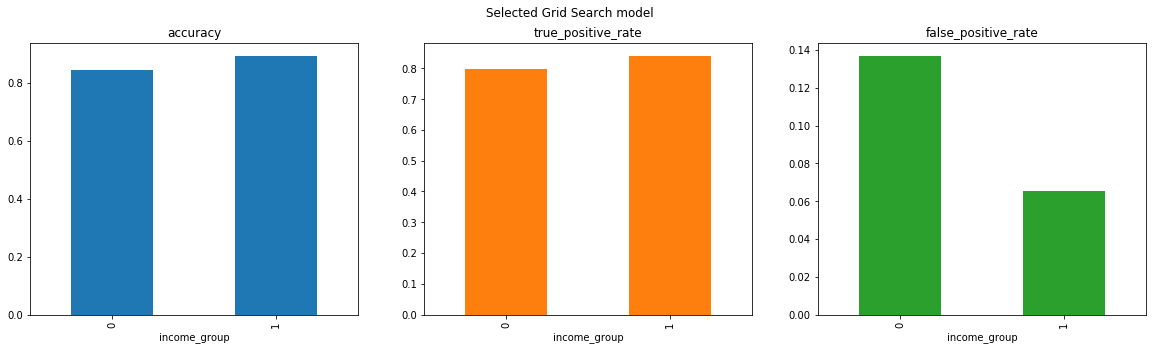

In [120]:
'''
TRAIN SET
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs_train = gs_dominant_model.predict(X_train)
metric_frame_gs_train = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "true_positive_rate": true_positive_rate,
                                        "false_positive_rate": false_positive_rate},
                               sensitive_features = A_train,
                               y_true = y_train,
                               y_pred = y_pred_gs_train)

gs_eo_diff_train = equalized_odds_difference(y_train, y_pred_gs_train, sensitive_features = A_train)

print(metric_frame_gs_train.overall)
print("-"*30)
print(metric_frame_gs_train.by_group)
print("true_positive_rate diff:", "{:.5f}".format(metric_frame_gs_train.difference()["true_positive_rate"]))
print("false_positive_rate diff:", "{:.5f}".format(metric_frame_gs_train.difference()["false_positive_rate"]))
print("equalized_odds_difference:", "{:.5f}".format(gs_eo_diff_train))
print("-"*30)
# # save model

# model_summary.loc["grid_search", "accuracy"] = metric_frame_gs.overall["accuracy"]
# model_summary.loc["grid_search", "accuracy_diff"] = metric_frame_gs.difference()["accuracy"]
# model_summary.loc["grid_search", "equalized_odds_diff"] = gs_eo_diff

# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)



metric_frame_gs_train.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Selected Grid Search model')

# plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_metric"))

accuracy              0.8322
true_positive_rate    0.6982
false_positive_rate   0.1077
dtype: object
------------------------------
             accuracy true_positive_rate false_positive_rate
income_group                                                
0              0.7931             0.5326              0.1370
1              0.8698             0.7814              0.0704
accuracy diff: 0.07665
true_positive_rate diff: 0.24881
false_positive_rate diff: 0.06666
equalized_odds_difference: 0.24881
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90a92a8ed0>,
      dtype=object)

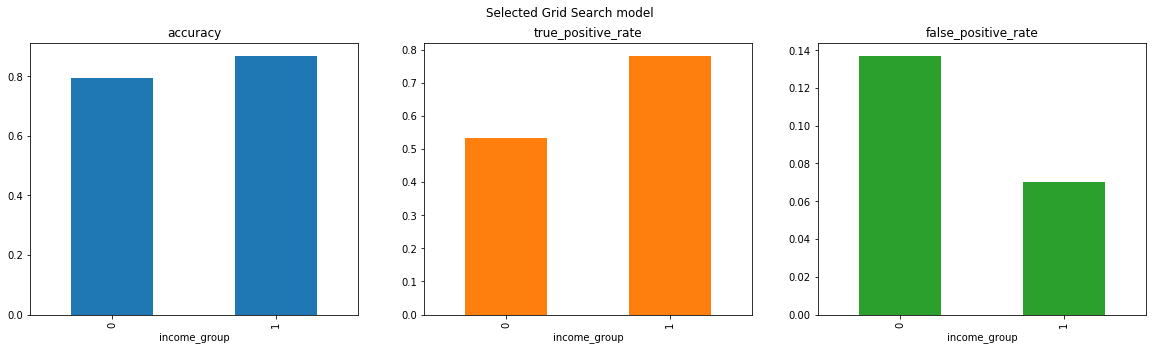

In [121]:
'''
TEST SET
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs = gs_dominant_model.predict(X_test)
metric_frame_gs = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "true_positive_rate": true_positive_rate,
                                        "false_positive_rate": false_positive_rate},
                               sensitive_features = A_test,
                               y_true = y_test,
                               y_pred = y_pred_gs)

gs_eo_diff = equalized_odds_difference(y_test, y_pred_gs, sensitive_features = A_test)

print(metric_frame_gs.overall)
print("-"*30)
print(metric_frame_gs.by_group)
print("accuracy diff:", "{:.5f}".format(metric_frame_gs.difference()["accuracy"]))
print("true_positive_rate diff:", "{:.5f}".format(metric_frame_gs.difference()["true_positive_rate"]))
print("false_positive_rate diff:", "{:.5f}".format(metric_frame_gs.difference()["false_positive_rate"]))
print("equalized_odds_difference:", "{:.5f}".format(gs_eo_diff))
print("-"*30)
# # save model

model_summary.loc["grid_search", "accuracy"] = metric_frame_gs.overall["accuracy"]
model_summary.loc["grid_search", "accuracy_diff"] = metric_frame_gs.difference()["accuracy"]
model_summary.loc["grid_search", "equalized_odds_diff"] = gs_eo_diff

# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)



metric_frame_gs.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Selected Grid Search model')

# plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_metric"))

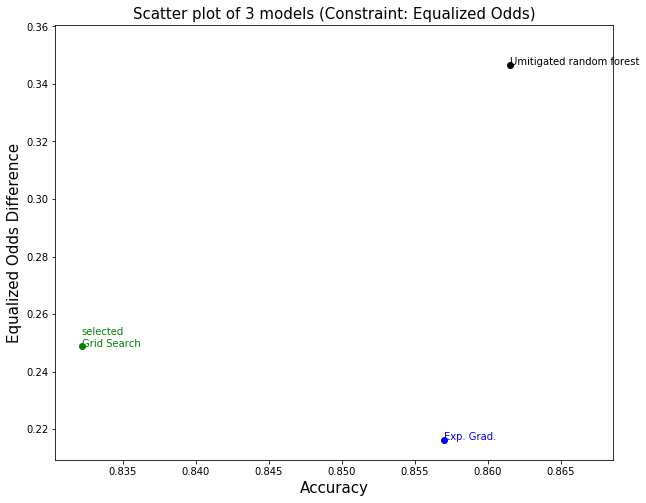

In [122]:
# plot only the dominated models

plt.figure(figsize = (10, 8))
# plt.scatter(r2_dominated, mae_diff_dominated)

# Label previous fair-unaware model
plt.scatter(metric_frame_rf_gs.overall["accuracy"], rf_gs_eo_diff, color = 'black')
plt.text(metric_frame_rf_gs.overall["accuracy"], rf_gs_eo_diff, "Umitigated random forest", color = 'black')

# Selected grid search model
plt.scatter(metric_frame_eg.overall["accuracy"], eg_eo_diff, color = 'blue')
plt.text(metric_frame_eg.overall["accuracy"],eg_eo_diff, "Exp. Grad.", color = 'blue')

# exponentiated gradient
plt.scatter(metric_frame_gs.overall['accuracy'], gs_eo_diff, color = 'green')
plt.text(metric_frame_gs.overall['accuracy'], gs_eo_diff, "selected\nGrid Search", color = 'green')

plt.xlabel("Accuracy", fontsize = 15)
plt.ylabel("Equalized Odds Difference", fontsize = 15)
plt.title("Scatter plot of 3 models (Constraint: Equalized Odds)", fontsize = 15)
# plt.xlim((0.806, 0.811))
plt.savefig(os.path.join(save_dir_models, CITY +"models_scatter_res"))

In [61]:
# model_summary.to_csv(os.path.join(save_dir_models, CITY +"model_summary.csv"))

### visualization

Text(0.5, 1, 'Outflow Class Ground Truth in 2019')

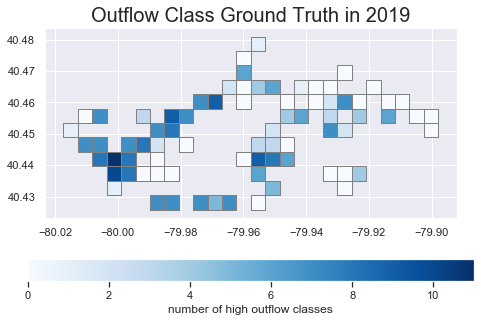

In [67]:
viz_df = pd.DataFrame({
    # "index": y_test.index,
    "cell_num": y_test_cell_num.cell_num.values,
    "y_pred_rf_gs": y_pred_rf_gs,
    "y_pred_eg": y_pred_eg,
    "y_pred_gs": y_pred_gs,
    "y_true": y_test.values})

# sum within a cell
viz_df = viz_df.groupby("cell_num").sum()
viz_df = viz_df.merge(geo_df, how='left', on = 'cell_num')
viz_df

# for row,col in unmitigated_df_plot.iterrows():
#     unmitigated_df_plot.at[row, 'geometry'] = shapely.wkt.loads(unmitigated_df_plot.loc[row]['geometry'])
#     unmitigated_df_plot.at[row, 'centroid'] = shapely.wkt.loads(unmitigated_df_plot.loc[row]['centroid'])
    
viz_df = gpd.GeoDataFrame(viz_df, crs='EPSG:2956', geometry='geometry')

viz_df.plot(column="y_true", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"})
plt.title("Outflow Class Ground Truth in 2019", fontsize = 20)
# plt.savefig("Figures/actual_geo.svg")

Text(0.5, 1, 'Unmitigated random forest outflow class in 2019')

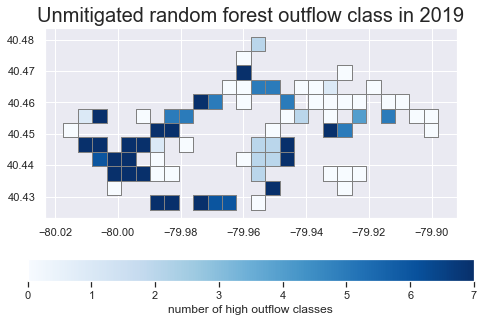

In [68]:
viz_df.plot(column="y_pred_rf_gs", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"})
plt.title("Unmitigated random forest outflow class in 2019", fontsize = 20)# plt.savefig("Figures/rf_geo.svg")

Text(0.5, 1, 'Exponentiated Gradient')

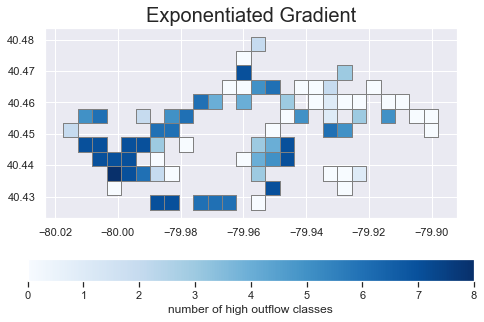

In [69]:
viz_df.plot(column="y_pred_eg", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"})
# plt.title("Mitigated with Exponentiated Gradient (low accuracy, low disparity)")
plt.title("Exponentiated Gradient", fontsize = 20)

Text(0.5, 1, 'Grid Search prediction 2019')

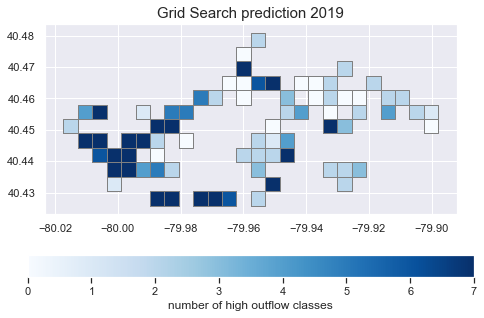

In [70]:
viz_df.plot(column="y_pred_gs", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"})
# plt.title("Mitigated with Exponentiated Gradient (low accuracy, low disparity)")
plt.title("Grid Search prediction 2019", fontsize = 15)
# plt.savefig("Figures/eg_geo.svg")

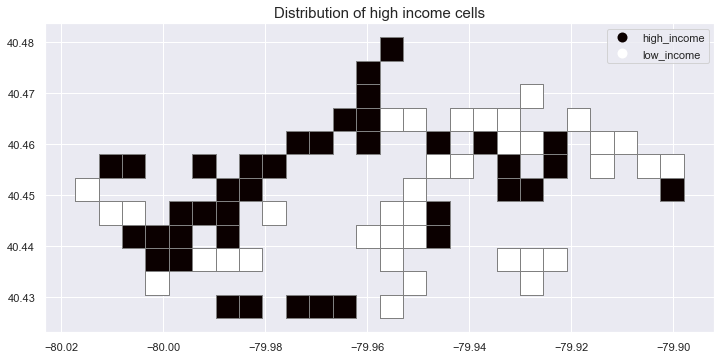

In [77]:
income_df = income_df.groupby("cell_num").sum()
income_df_plot = income_df.merge(geo_df, how='left', on = 'cell_num')
geo_cells_income = gpd.GeoDataFrame(income_df_plot, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])
geo_cells_income["bi_income"] = geo_cells_income["income"].apply(lambda x: "high_income" if x > 0 else "low_income")
geo_cells_income.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(12, 8),  
                    legend = True, categorical = True)
plt.title("Distribution of high income cells", fontsize = 15)
plt.savefig(os.path.join(save_dir_models, CITY + "income_group_distribution"))

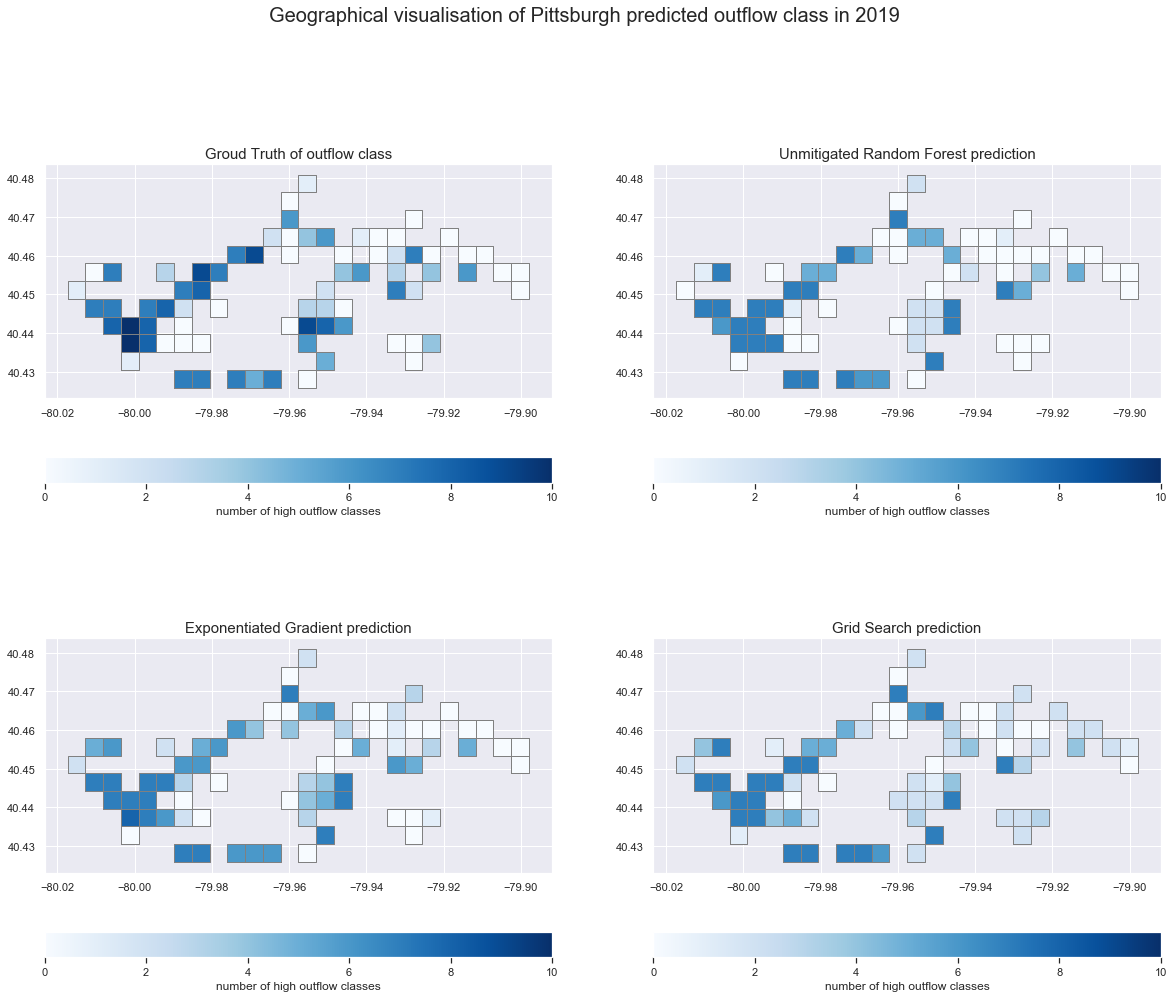

In [79]:
fig, axes = plt.subplots(2,2, figsize = (20, 16))

ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[1,0]
ax4=axes[1,1]

viz_df.plot(column="y_true", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"}, ax = ax1, vmax = 10)
ax1.set_title("Groud Truth of outflow class", size = 15)

viz_df.plot(column="y_pred_rf_gs", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"}, ax = ax2, vmax = 10)
ax2.set_title("Unmitigated Random Forest prediction", size = 15)

viz_df.plot(column="y_pred_eg", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"}, ax = ax3, vmax = 10)
ax3.set_title("Exponentiated Gradient prediction", size = 15)

viz_df.plot(column="y_pred_gs", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"}, ax = ax4, vmax = 10)
ax4.set_title("Grid Search prediction", size = 15)

fig.suptitle('Geographical visualisation of Pittsburgh predicted outflow class in 2019', fontsize = 20)

plt.savefig(os.path.join(save_dir_models, CITY + "geographical_visualization"))
